In [158]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

In [159]:
files = [file for file in os.listdir('./parametros')]

param = pd.DataFrame()
for file in files:
  df = pd.read_csv('./parametros/'+file)
  param = pd.concat([param, df], axis= 0)

Revolviendo los datos

In [160]:
from sklearn.model_selection import train_test_split
param = param.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(param, test_size=0.2, random_state=42)

Normalizando

# Ahora invertimos la red, de input será Fracción vol, espesor y radio. Output longitud de onda e Índice de absorción

Normalizacion

In [161]:
# Cargar DataFrame
df = train_df
# Separar datos de entrada y salida
Y = df[['Índice de absorción', 'Longitud de onda']]
X = df[['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']]

In [162]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y)

Esto se hace para poder ver los errores

In [163]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [164]:
# Creamos el modelo de la red neuronal
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='linear'))

In [165]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [179]:
history = model.fit(X, Y, validation_data=(X_val, y_val),epochs=100, batch_size=10)

Epoch 1/100
3072/3072 [==============================] - 2s 783us/step - loss: 0.0437 - val_loss: 0.0436
Epoch 2/100
3072/3072 [==============================] - 2s 791us/step - loss: 0.0437 - val_loss: 0.0438
Epoch 3/100
3072/3072 [==============================] - 2s 801us/step - loss: 0.0437 - val_loss: 0.0436
Epoch 4/100
3072/3072 [==============================] - 2s 806us/step - loss: 0.0437 - val_loss: 0.0435
Epoch 5/100
3072/3072 [==============================] - 2s 807us/step - loss: 0.0437 - val_loss: 0.0435
Epoch 6/100
3072/3072 [==============================] - 2s 738us/step - loss: 0.0437 - val_loss: 0.0435
Epoch 7/100
3072/3072 [==============================] - 2s 752us/step - loss: 0.0437 - val_loss: 0.0436
Epoch 8/100
3072/3072 [==============================] - 2s 787us/step - loss: 0.0437 - val_loss: 0.0435
Epoch 9/100
3072/3072 [==============================] - 3s 822us/step - loss: 0.0437 - val_loss: 0.0435
Epoch 10/100
3072/3072 [==============================]

Normalizando los datos de test

In [167]:
x_pred = test_df[['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']]

In [168]:
y_normalized = scaler_Y.transform(test_df[['Índice de absorción', 'Longitud de onda']])

In [169]:
x_pred_norm = scaler_X.transform(x_pred) 
pred_norm = model.predict(x_pred_norm)

240/240 [==============================] - 0s 734us/step


In [170]:
test_loss = model.evaluate(x_pred_norm, y_normalized)
test_loss

240/240 [==============================] - 0s 802us/step - loss: 0.0435


0.04345863685011864

Calculando error cuadrático medio 

In [171]:
# Calcular error cuadrático medio (MSE) en los datos normalizados
mse = np.mean(np.square(y_normalized - pred_norm))
print("MSE: ", mse)

# Desnormalizar el MSE
mse_denormalized = scaler_Y.inverse_transform(np.array([[mse, 0]]))[0][0]
print("MSE desnormalizado: ", mse_denormalized)

MSE:  0.0434586142294496
MSE desnormalizado:  0.006002969119762228


Gráfica de función de pérdida contra pérdida, para ver si se necesitan más épocas en el modelo

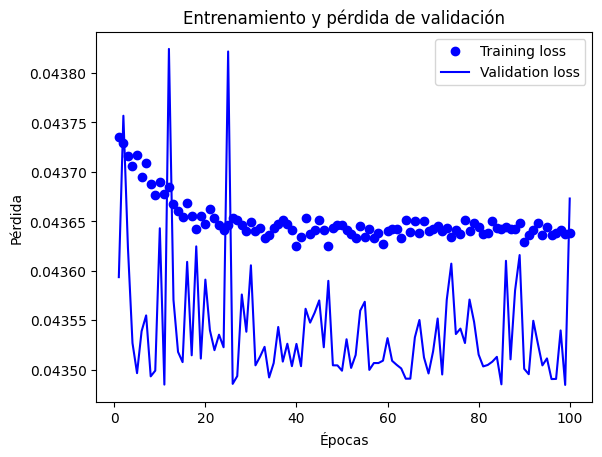

In [183]:
# Graficar la función de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Entrenamiento y pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [173]:
pred = scaler_Y.inverse_transform(pred_norm)
pred

array([[3.5489635e-03, 6.0403351e+02],
       [1.7142398e-03, 6.0207410e+02],
       [1.7142398e-03, 6.0207410e+02],
       ...,
       [2.9205407e-03, 6.0438745e+02],
       [1.7138716e-03, 6.0212366e+02],
       [1.7130185e-03, 6.0223859e+02]], dtype=float32)

# Renombrando las columnas

In [174]:
predicciones = pd.DataFrame(pred)
predicciones.columns = ['Índice de absorción', 'Longitud de onda']
predicciones

,Índice de absorción,Longitud de onda
0,0.003549,604.033508
1,0.001714,602.074097
2,0.001714,602.074097
3,0.007420,602.540588
4,0.002154,605.533997
...,...,...
7675,0.004806,603.325684
7676,0.001705,603.351868
7677,0.002921,604.387451
7678,0.001714,602.123657


# Probando la accurancy del modelo

Primero lo haremos por cada parámetro. Se le restará los valores predichos por la red a los valores originales de test. Se contarán el número de ceros y ese será lo acertada que es nuestra red. De tener valores inferiores a 80% en número de ceros este rango se incrementará hasta llegar a un valor que el 80% de los valores sean menores a este

# Longitud de onda

In [175]:
redondeo = predicciones['Longitud de onda'].to_numpy()
test_df_long = test_df['Longitud de onda'].to_numpy()
dif = redondeo - test_df_long 
#count_nonzero() cuenta el número de elementos distintos de cero en el arreglo, mientras que la función size() devuelve el tamaño total del arreglo. 
total = dif.size
num_zeros = dif.size - np.count_nonzero(dif)
porcentaje = num_zeros*100/total
print("presición del ", porcentaje, "%.")

presición del  0.0 %.


In [176]:
# Se agrega umbral hasta llegar a 80% de aceptación
i = 0
while(porcentaje < 80):
    umbral = i
    num = np.count_nonzero(np.abs(dif) <= umbral)
    porcentaje = num*100/total
    print("presición del ", porcentaje, "%. Con el redondeo para arriba en espesor y un rango de", umbral)
    i = i + 1

presición del  0.0 %. Con el redondeo para arriba en espesor y un rango de 0
presición del  0.4166666666666667 %. Con el redondeo para arriba en espesor y un rango de 1
presición del  0.8203125 %. Con el redondeo para arriba en espesor y un rango de 2
presición del  1.171875 %. Con el redondeo para arriba en espesor y un rango de 3
presición del  1.484375 %. Con el redondeo para arriba en espesor y un rango de 4
presición del  1.8098958333333333 %. Con el redondeo para arriba en espesor y un rango de 5
presición del  2.2526041666666665 %. Con el redondeo para arriba en espesor y un rango de 6
presición del  2.5390625 %. Con el redondeo para arriba en espesor y un rango de 7
presición del  2.890625 %. Con el redondeo para arriba en espesor y un rango de 8
presición del  3.3072916666666665 %. Con el redondeo para arriba en espesor y un rango de 9
presición del  3.7109375 %. Con el redondeo para arriba en espesor y un rango de 10
presición del  4.010416666666667 %. Con el redondeo para ar

In [177]:
redondeo = predicciones['Índice de absorción'].to_numpy()
test_df_long = test_df['Índice de absorción'].to_numpy()
dif = redondeo - test_df_long 
#count_nonzero() cuenta el número de elementos distintos de cero en el arreglo, mientras que la función size() devuelve el tamaño total del arreglo. 
total = dif.size
num_zeros = dif.size - np.count_nonzero(dif)
porcentaje = num_zeros*100/total
print("presición del ", porcentaje, "%.")

presición del  0.0 %.


In [178]:
# Se agrega umbral hasta llegar a 80% de aceptación
i = 0
while(porcentaje < 80):
    umbral = i
    num = np.count_nonzero(np.abs(dif) <= umbral)
    porcentaje = num*100/total
    print("presición del ", porcentaje, "%. Con el redondeo para arriba en espesor y un rango de", umbral)
    i = i + .001

presición del  0.0 %. Con el redondeo para arriba en espesor y un rango de 0
presición del  41.419270833333336 %. Con el redondeo para arriba en espesor y un rango de 0.001
presición del  68.93229166666667 %. Con el redondeo para arriba en espesor y un rango de 0.002
presición del  74.58333333333333 %. Con el redondeo para arriba en espesor y un rango de 0.003
presición del  78.19010416666667 %. Con el redondeo para arriba en espesor y un rango de 0.004
presición del  81.53645833333333 %. Con el redondeo para arriba en espesor y un rango de 0.005
